<a href="https://colab.research.google.com/github/sterzoutt/DS3000A-GROUP/blob/main/DS3000A_GROUP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
accuracy_score, precision_score, recall_score, f1_score,
roc_auc_score, roc_curve, confusion_matrix
)
from sklearn.metrics import roc_curve, auc


from xgboost import XGBClassifier

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.nn.functional as F
import torch.nn.utils as utils

df = pd.read_csv("diabetes_dataset.csv");
display(df.head())
display(df.shape)

,age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,family_history_diabetes,hypertension_history,cardiovascular_history,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,7.9,7.9,0,0,0,30.5,0.89,134,78,68,239,41,160,145,136,236,6.36,8.18,29.6,Type 2,1
1,48,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,6.5,8.7,0,0,0,23.1,0.80,129,76,67,116,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,10.0,8.1,1,0,0,22.2,0.81,115,73,74,213,66,99,36,118,195,5.07,7.51,44.7,Type 2,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,6.6,5.2,0,0,0,26.8,0.88,120,93,68,171,50,79,140,139,253,5.28,9.03,38.2,Type 2,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,7.4,5.0,0,0,0,21.2,0.78,92,67,67,210,52,125,160,137,184,12.74,7.20,23.5,Type 2,1


(100000, 31)

# Data manipulation

In [63]:
#Q1.2
#dataset has no null values to replace (good)
df.isnull().sum()

age                                   0
gender                                0
ethnicity                             0
education_level                       0
income_level                          0
employment_status                     0
smoking_status                        0
alcohol_consumption_per_week          0
physical_activity_minutes_per_week    0
diet_score                            0
sleep_hours_per_day                   0
screen_time_hours_per_day             0
family_history_diabetes               0
hypertension_history                  0
cardiovascular_history                0
bmi                                   0
waist_to_hip_ratio                    0
systolic_bp                           0
diastolic_bp                          0
heart_rate                            0
cholesterol_total                     0
hdl_cholesterol                       0
ldl_cholesterol                       0
triglycerides                         0
glucose_fasting                       0


In [64]:
df['diagnosed_diabetes'].value_counts(normalize = True)
df['diagnosed_diabetes'].value_counts(normalize = False)



diagnosed_diabetes
1    59998
0    40002
Name: count, dtype: int64

In [65]:
X = df.drop('diagnosed_diabetes', axis=1)
y = df['diagnosed_diabetes']


In [66]:
display(y.value_counts(normalize=False))
display(y.value_counts(normalize=True))

diagnosed_diabetes
1    59998
0    40002
Name: count, dtype: int64

diagnosed_diabetes
1    0.59998
0    0.40002
Name: proportion, dtype: float64

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

df = df.drop(columns=['diabetes_stage', 'diabetes_risk_score'], axis=1)
df = pd.get_dummies(df, columns=['gender', 'ethnicity', 'education_level', 'income_level', 'employment_status', 
                                 'smoking_status'], drop_first=True)

correlations_with_target = df.corr()['diagnosed_diabetes'].drop('diagnosed_diabetes')

correlations_with_target = correlations_with_target.sort_values(ascending=False)

corr_df = correlations_with_target.to_frame(name='Correlation with Diagnosed Diabetes')



In [68]:
# initialize an empty list to store the new column order
ordered_columns = []

ordered_columns.append('diagnosed_diabetes')

# iterate through the original DataFrame columns
for col in df.columns:
    if col != 'diagnosed_diabetes':
        ordered_columns.append(col)

# new df with proper ordering
df = df[ordered_columns]
pd.set_option('display.max_columns', None)
display(df.head())

,diagnosed_diabetes,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,family_history_diabetes,hypertension_history,cardiovascular_history,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,heart_rate,cholesterol_total,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,gender_Male,gender_Other,ethnicity_Black,ethnicity_Hispanic,ethnicity_Other,ethnicity_White,education_level_Highschool,education_level_No formal,education_level_Postgraduate,income_level_Low,income_level_Lower-Middle,income_level_Middle,income_level_Upper-Middle,employment_status_Retired,employment_status_Student,employment_status_Unemployed,smoking_status_Former,smoking_status_Never
0,1,58,0,215,5.7,7.9,7.9,0,0,0,30.5,0.89,134,78,68,239,41,160,145,136,236,6.36,8.18,True,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,True
1,0,48,1,143,6.7,6.5,8.7,0,0,0,23.1,0.80,129,76,67,116,55,50,30,93,150,2.00,5.63,False,False,False,False,False,True,True,False,False,False,False,True,False,False,False,False,True,False
2,1,60,1,57,6.4,10.0,8.1,1,0,0,22.2,0.81,115,73,74,213,66,99,36,118,195,5.07,7.51,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,True,False,True
3,1,74,0,49,3.4,6.6,5.2,0,0,0,26.8,0.88,120,93,68,171,50,79,140,139,253,5.28,9.03,False,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True
4,1,46,1,109,7.2,7.4,5.0,0,0,0,21.2,0.78,92,67,67,210,52,125,160,137,184,12.74,7.20,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,True


# Selected Features and Correlation Matrix no barrier = DS1

In [69]:
correlationMatrix = df.corr()

In [70]:
cm = correlationMatrix['diagnosed_diabetes'].sort_values(ascending=False)
print(cm)

diagnosed_diabetes                    1.000000
hba1c                                 0.679397
glucose_postprandial                  0.629832
glucose_fasting                       0.510919
family_history_diabetes               0.197926
age                                   0.137713
bmi                                   0.097057
systolic_bp                           0.095481
waist_to_hip_ratio                    0.078918
ldl_cholesterol                       0.067475
cholesterol_total                     0.058173
insulin_level                         0.057715
triglycerides                         0.056230
diastolic_bp                          0.035619
cardiovascular_history                0.029793
hypertension_history                  0.027524
heart_rate                            0.022785
screen_time_hours_per_day             0.018127
gender_Other                          0.006430
income_level_Lower-Middle             0.004587
ethnicity_Other                       0.003608
education_lev

# Selected Features and Correlation Matrix >=0.05 = DS2

In [71]:
selected_features_low = correlationMatrix['diagnosed_diabetes']
selected_features_low = selected_features_low[selected_features_low.abs() >= 0.05]
selected_features_low_list = selected_features_low.sort_values(ascending=False)
print(selected_features_low_list)


diagnosed_diabetes                    1.000000
hba1c                                 0.679397
glucose_postprandial                  0.629832
glucose_fasting                       0.510919
family_history_diabetes               0.197926
age                                   0.137713
bmi                                   0.097057
systolic_bp                           0.095481
waist_to_hip_ratio                    0.078918
ldl_cholesterol                       0.067475
cholesterol_total                     0.058173
insulin_level                         0.057715
triglycerides                         0.056230
hdl_cholesterol                      -0.051227
physical_activity_minutes_per_week   -0.100774
Name: diagnosed_diabetes, dtype: float64


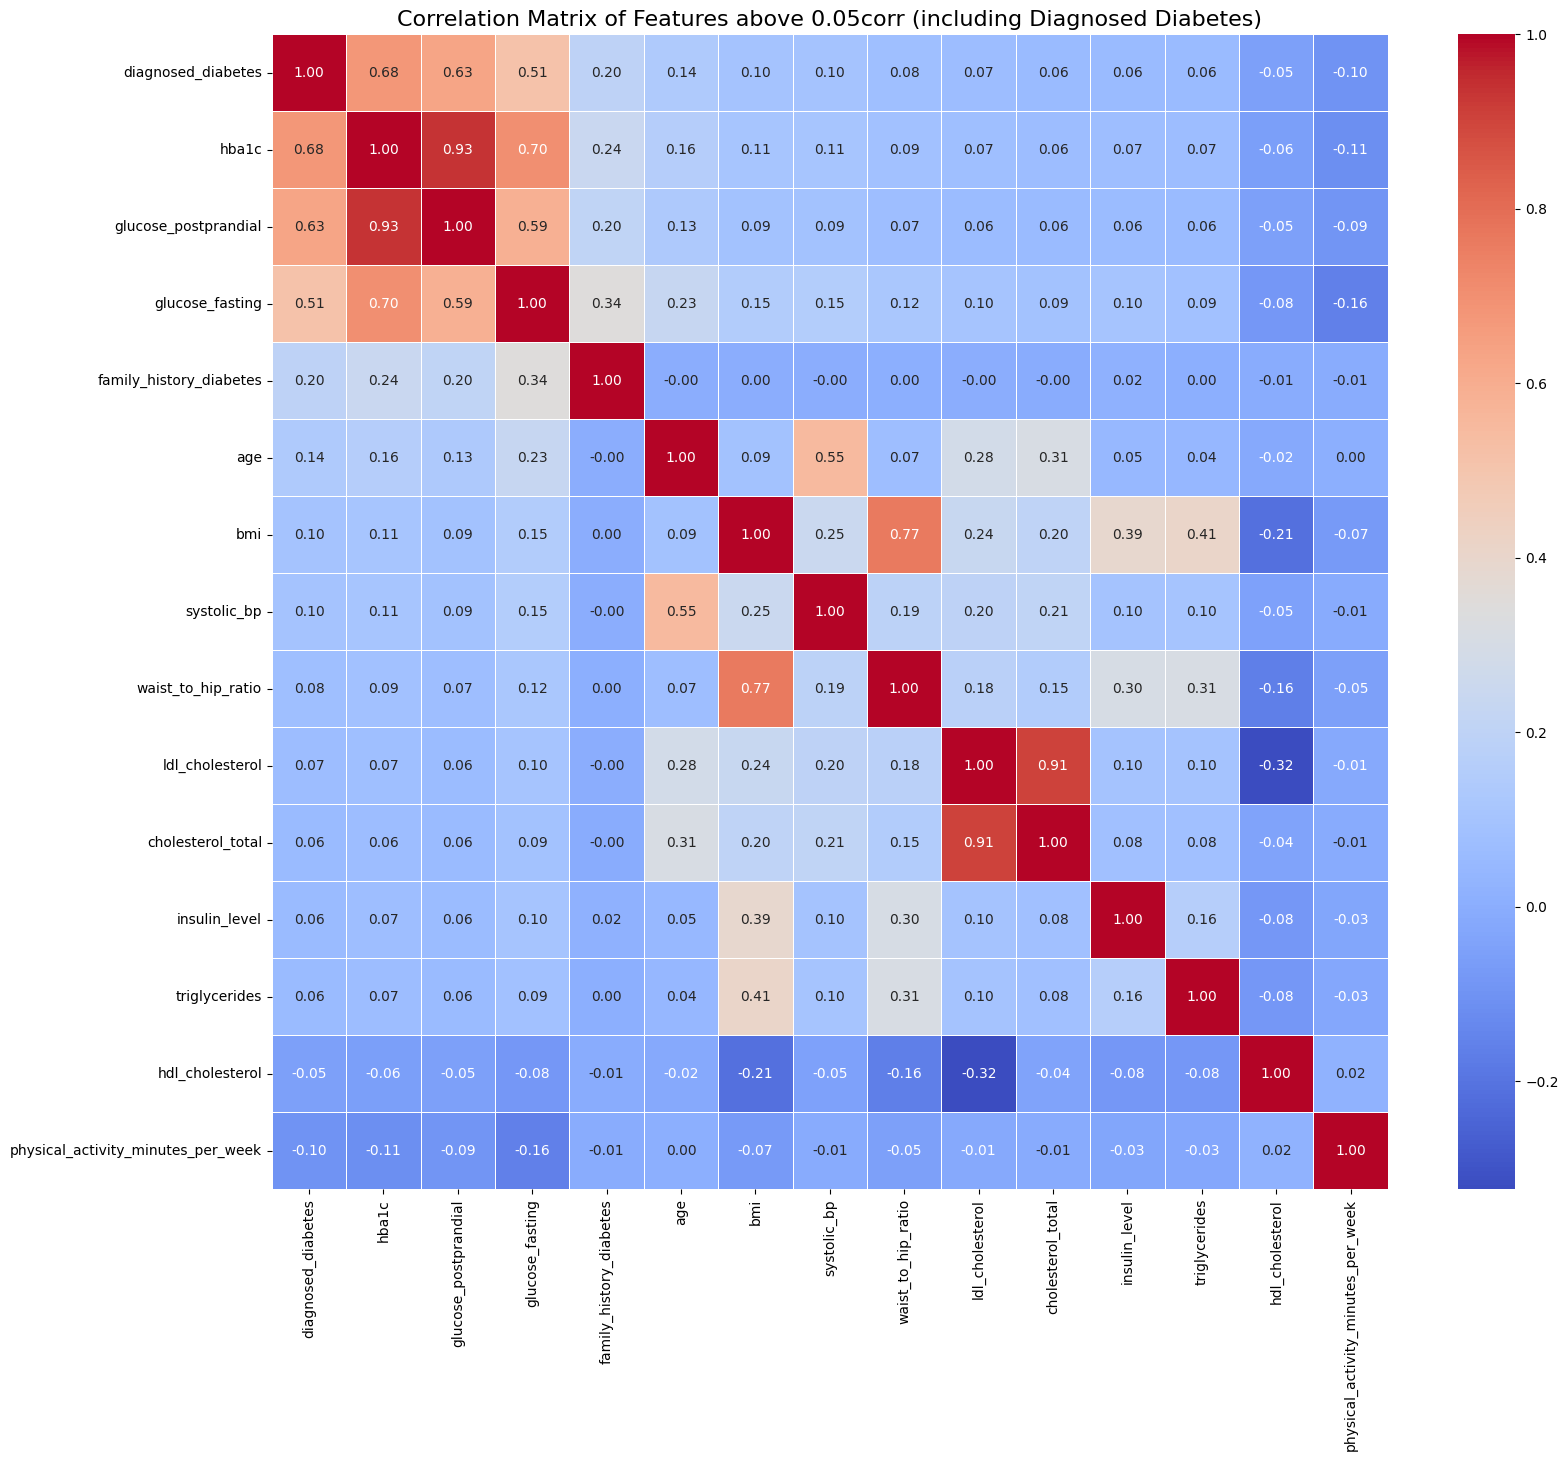

In [72]:
cols = selected_features_low_list.index
correlationMatrix = df[cols].corr()
plt.figure(figsize=(18, 15))
sns.heatmap(correlationMatrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Features above 0.05corr (including Diagnosed Diabetes)', fontsize=16)
plt.show()

# Selected Features and Correlation Matrix >=0.10 = DS3

In [73]:
selected_features_high = correlationMatrix['diagnosed_diabetes']
selected_features_high = selected_features_high[selected_features_high.abs() >= 0.10]
selected_features_high = selected_features_high.sort_values(ascending=False)
print(selected_features_high)

diagnosed_diabetes                    1.000000
hba1c                                 0.679397
glucose_postprandial                  0.629832
glucose_fasting                       0.510919
family_history_diabetes               0.197926
age                                   0.137713
physical_activity_minutes_per_week   -0.100774
Name: diagnosed_diabetes, dtype: float64


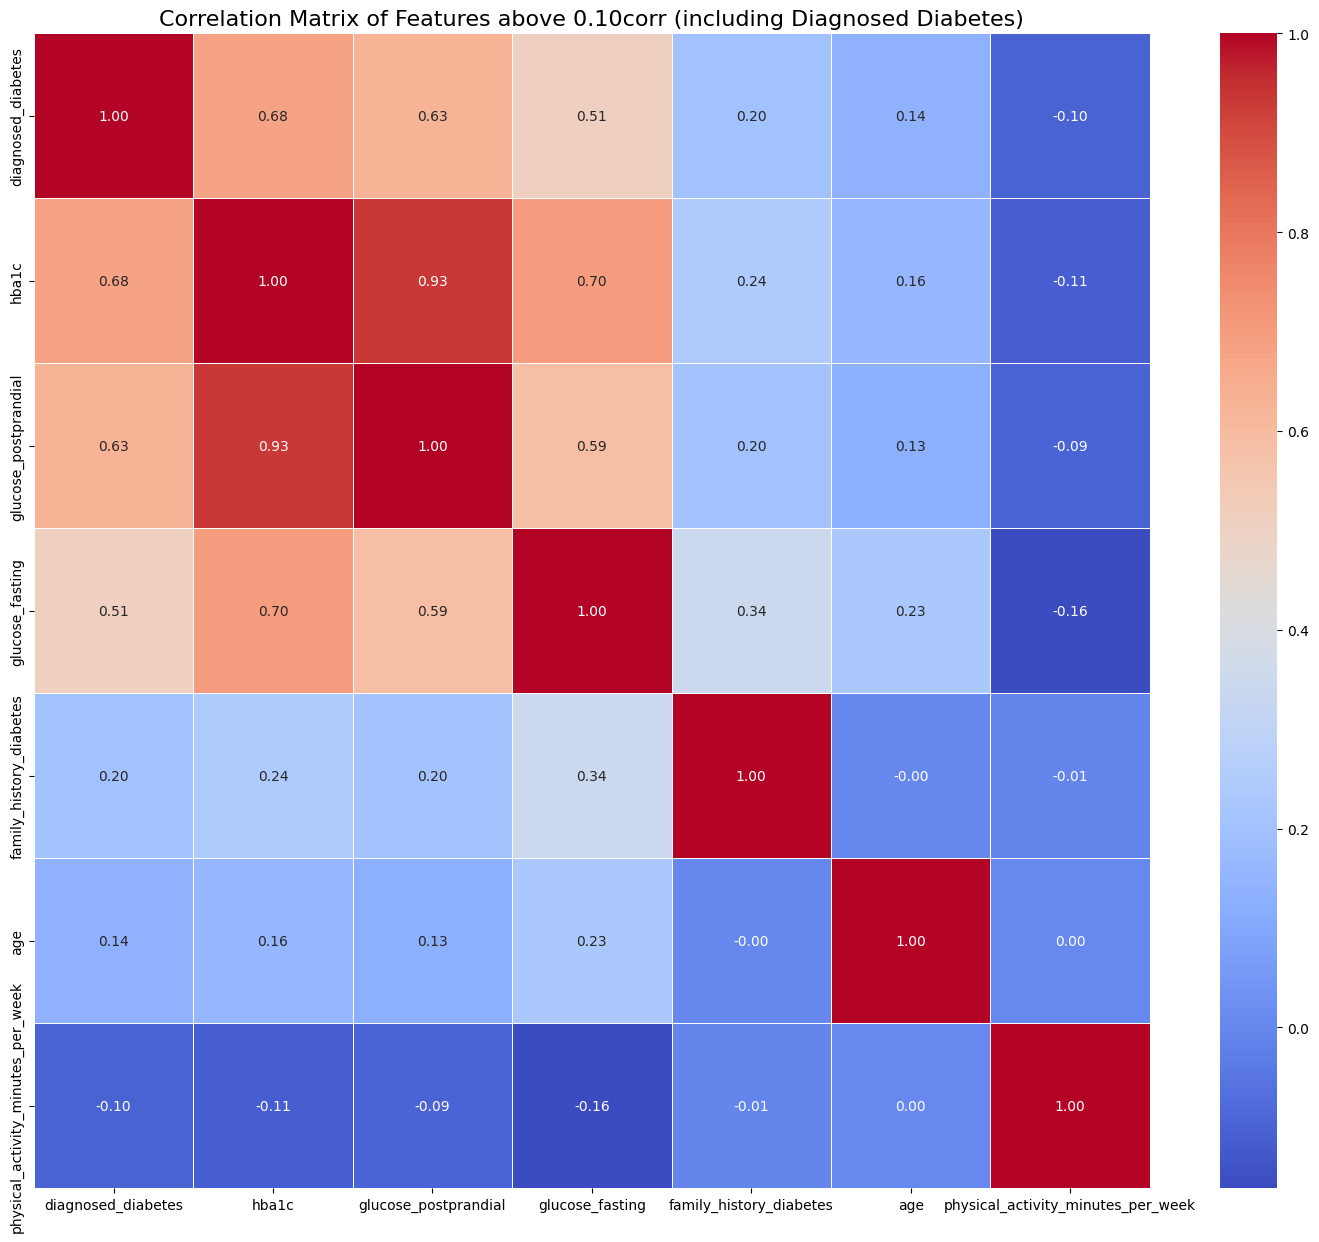

In [74]:
cols = selected_features_high.index
correlationMatrix = df[cols].corr()
plt.figure(figsize=(18, 15))
sns.heatmap(correlationMatrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Features above 0.10corr (including Diagnosed Diabetes)', fontsize=16)
plt.show()

# Logistic Initialization 

In [75]:
def LogisticRegressionInitialization(selected_features_low, features_to_scale):
    cols = selected_features_low.index.difference(['diagnosed_diabetes'])
    X = df[cols]
    y = df['diagnosed_diabetes']
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=42
    )
    
    print(X_train.shape)
    print(X_test.shape)
    
    
    
    
    
    scaler = StandardScaler()


    X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])
    X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])
    
    
    print("Scaled training data:")
    print(X_train[features_to_scale].head())
    
    print("Scaled test data:")
    print(X_test[features_to_scale].head())
    
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    
    print(X_train.dtypes)
    print(X_test.dtypes)
    
    lasso = LogisticRegression(
        penalty='l1',
        solver='liblinear',
        max_iter=1000
    )
    
    
    ridge = LogisticRegression(
        penalty='l2',
        solver='lbfgs',
        max_iter=1000
    )

    lasso.fit(X_train, y_train)
    ridge.fit(X_train, y_train)
    
    lasso_probs = lasso.predict_proba(X_test)[:, 1]
    lasso_preds = (lasso_probs > 0.5).astype(int)
    
    
    ridge_probs = ridge.predict_proba(X_test)[:, 1]
    ridge_preds = (ridge_probs > 0.5).astype(int)
    
    print("L1 Predictions:", lasso)
    print("L2 Predictions:", ridge)
    
    features = X_train.columns
    
    def evaluate_model(name, y_true, y_pred, y_prob):
        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_prob)
        print(f"{name} → Accuracy: {acc:.4f}, F1: {f1:.4f}, ROC AUC: {auc:.4f}")
        return [auc, acc]
    
    lasso_auc_acc = evaluate_model('LASSO Logistic Regression', y_test, lasso_preds, lasso_probs)
    ridge_auc_acc = evaluate_model('Ridge Logistic Regression', y_test, ridge_preds, ridge_probs)
    
    # Coefficient comparison
    coeff_df = pd.DataFrame({
    'Feature': X_train.columns,
    'LASSO Coeff': lasso.coef_[0],
    'Ridge Coeff': ridge.coef_[0]
    })
    
    coeff_df_melted = coeff_df.melt(id_vars='Feature', var_name='Model', value_name='Coefficient')
    plt.figure(figsize=(10,6))
    sns.barplot(data=coeff_df_melted, x='Feature', y='Coefficient', hue='Model')
    plt.xticks(rotation=45)
    plt.title('Feature Coefficients: LASSO vs Ridge')
    plt.show()


    fpr_lasso, tpr_lasso, _ = roc_curve(y_test, lasso_probs)
    auc_lasso = auc(fpr_lasso, tpr_lasso)
    
    # Ridge ROC
    fpr_ridge, tpr_ridge, _ = roc_curve(y_test, ridge_probs)
    auc_ridge = auc(fpr_ridge, tpr_ridge)
    
    plt.figure(figsize=(8,6))
    
    # Plot both curves
    plt.plot(fpr_lasso, tpr_lasso, label=f"LASSO (AUC = {auc_lasso:.3f})")
    plt.plot(fpr_ridge, tpr_ridge, label=f"Ridge (AUC = {auc_ridge:.3f})")
    
    # Diagonal line for reference
    plt.plot([0,1], [0,1], linestyle='--', color='grey')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve: LASSO vs Ridge Logistic Regression')
    plt.legend()
    plt.tight_layout()
    plt.show()


    y_pred = lasso.predict(X_test)
    matrix = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(matrix, annot=True, cmap='Blues', fmt='d')  # <-- forces normal integer format
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    return [X_train, X_test, y_train, y_test, lasso_auc_acc, ridge_auc_acc]


# Logistic Regression DS1

(80000, 40)
(20000, 40)
Scaled training data:
            age  physical_activity_minutes_per_week       bmi  \
27589 -1.865972                            0.128714  0.109490   
84374  1.019899                           -0.567335  0.360223   
69440 -1.288798                            0.211296 -2.955025   
66183 -0.519232                           -0.555537  0.415942   
16613  0.186203                           -0.307791 -0.280539   

       waist_to_hip_ratio  systolic_bp  cholesterol_total  hdl_cholesterol  \
27589           -0.341643     0.294819          -0.092821        -2.148904   
84374            0.084515     1.906492           1.313031         0.190124   
69440           -1.407039    -1.667218          -1.186262        -0.297174   
66183           -0.128564     0.575110           0.938137         1.944395   
16613           -0.341643    -0.826345           0.219590        -1.369228   

       ldl_cholesterol  triglycerides  glucose_fasting  glucose_postprandial  \
27589         

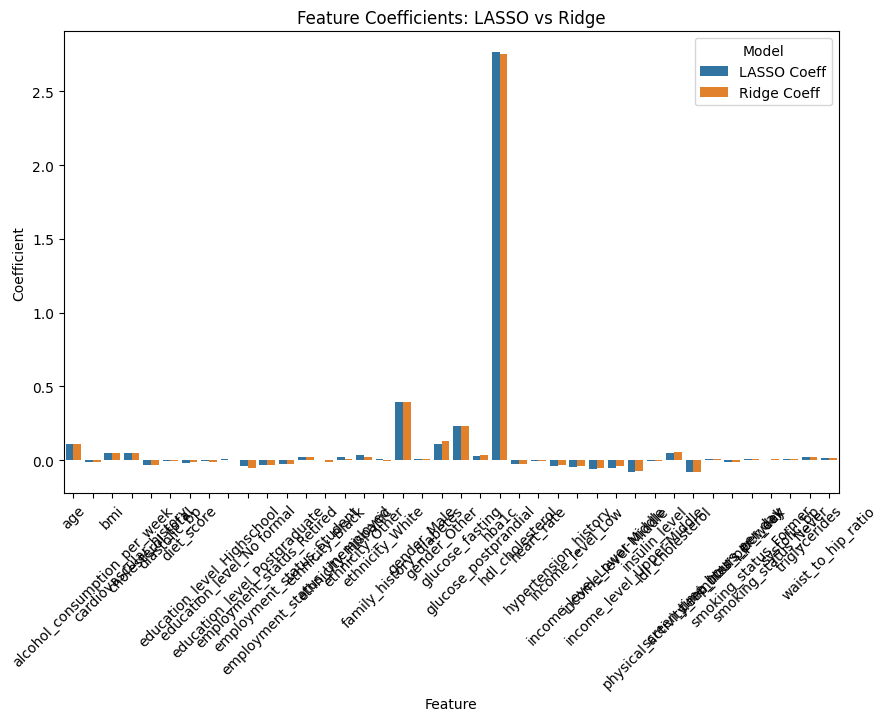

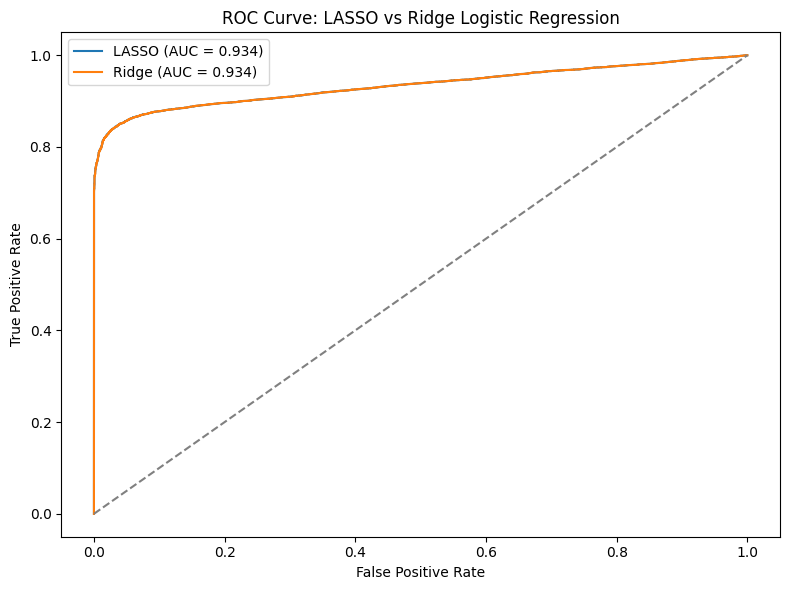

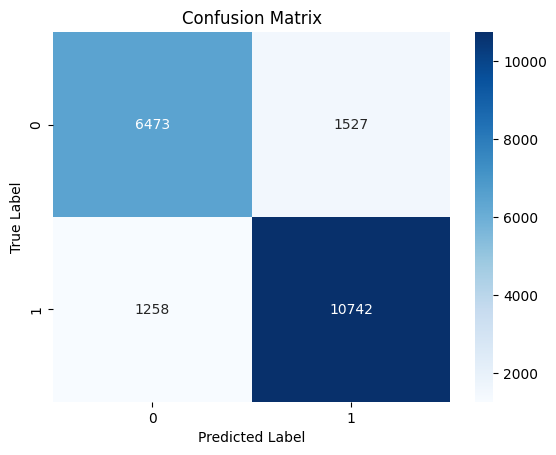

In [76]:
features_to_scale = [
    'age',
    'physical_activity_minutes_per_week',
    'bmi',
    'waist_to_hip_ratio',
    'systolic_bp',
    'cholesterol_total',
    'hdl_cholesterol',
    'ldl_cholesterol',
    'triglycerides',
    'glucose_fasting',
    'glucose_postprandial',
    'insulin_level',
    'hba1c',
    'diet_score',
    'sleep_hours_per_day',
    'screen_time_hours_per_day',
    'diastolic_bp',
    'heart_rate',
]

DS1_splits = LogisticRegressionInitialization(cm, features_to_scale)

# Logistic Regression DS2

(80000, 14)
(20000, 14)
Scaled training data:
            age  physical_activity_minutes_per_week       bmi  \
27589 -1.865972                            0.128714  0.109490   
84374  1.019899                           -0.567335  0.360223   
69440 -1.288798                            0.211296 -2.955025   
66183 -0.519232                           -0.555537  0.415942   
16613  0.186203                           -0.307791 -0.280539   

       waist_to_hip_ratio  systolic_bp  cholesterol_total  hdl_cholesterol  \
27589           -0.341643     0.294819          -0.092821        -2.148904   
84374            0.084515     1.906492           1.313031         0.190124   
69440           -1.407039    -1.667218          -1.186262        -0.297174   
66183           -0.128564     0.575110           0.938137         1.944395   
16613           -0.341643    -0.826345           0.219590        -1.369228   

       ldl_cholesterol  triglycerides  glucose_fasting  glucose_postprandial  \
27589         

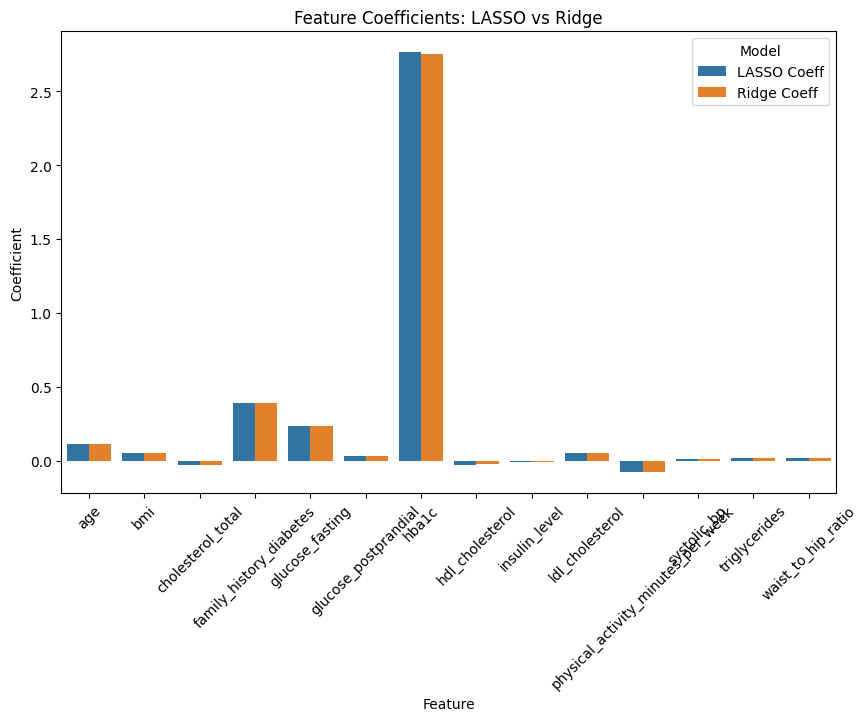

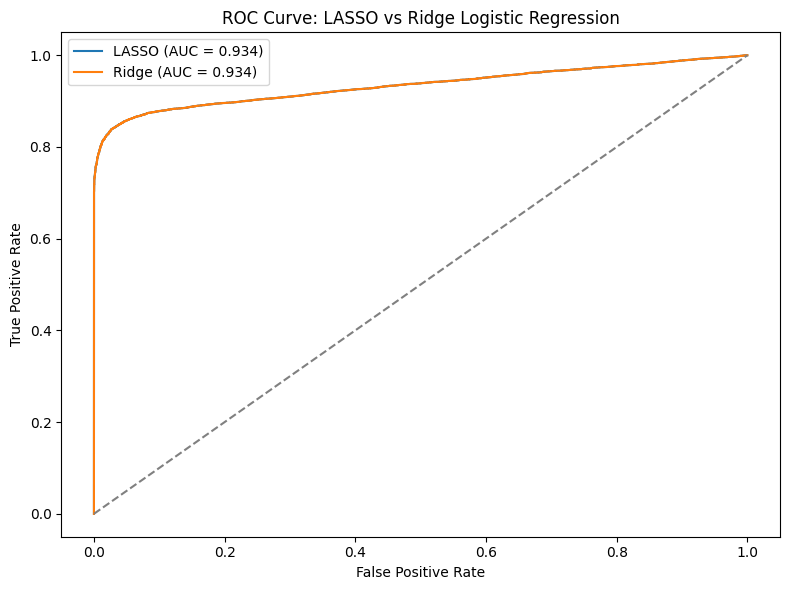

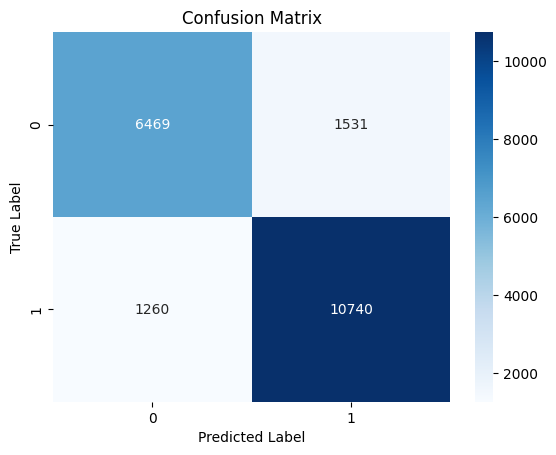

In [77]:
features_to_scale = [
    'age',
    'physical_activity_minutes_per_week',
    'bmi',
    'waist_to_hip_ratio',
    'systolic_bp',
    'cholesterol_total',
    'hdl_cholesterol',
    'ldl_cholesterol',
    'triglycerides',
    'glucose_fasting',
    'glucose_postprandial',
    'insulin_level',
    'hba1c',
]

DS2_splits = LogisticRegressionInitialization(selected_features_low, features_to_scale)

# Logistic Regression DS3

(80000, 6)
(20000, 6)
Scaled training data:
            age  physical_activity_minutes_per_week  glucose_fasting  \
27589 -1.865972                            0.128714        -0.375891   
84374  1.019899                           -0.567335         1.611352   
69440 -1.288798                            0.211296         1.390547   
66183 -0.519232                           -0.555537         0.360125   
16613  0.186203                           -0.307791         0.728133   

       glucose_postprandial     hba1c  
27589              0.289025  0.021885  
84374             -0.843218 -0.457752  
69440              1.324219  1.755955  
66183             -1.102016 -0.740614  
16613              2.003564  1.940430  
Scaled test data:
            age  physical_activity_minutes_per_week  glucose_fasting  \
66593  1.981856                            2.110684        -0.007883   
52573  0.442725                           -0.567335         1.022539   
76795 -0.070319                           -1.3341

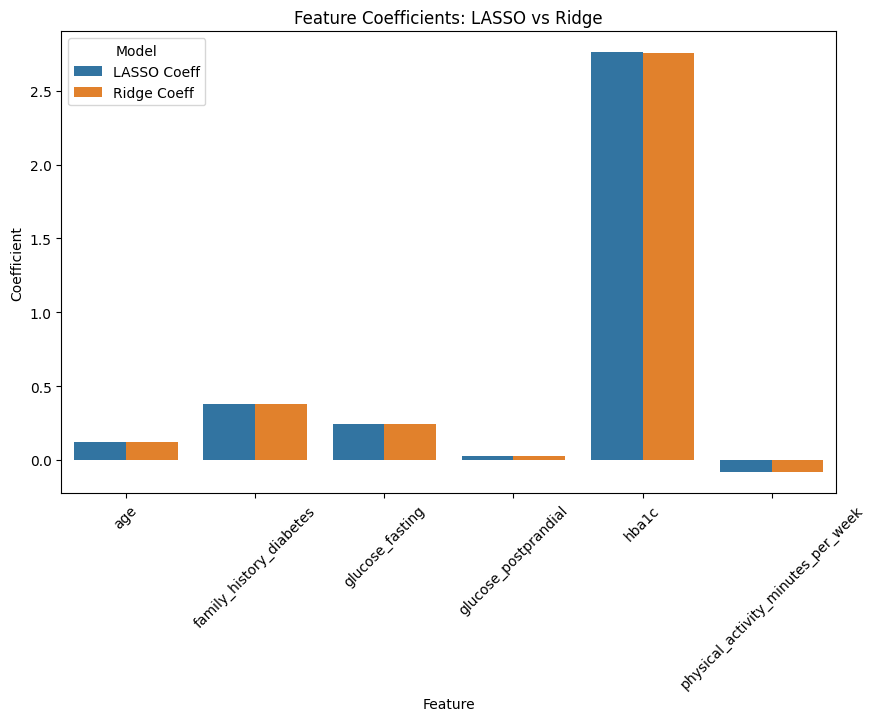

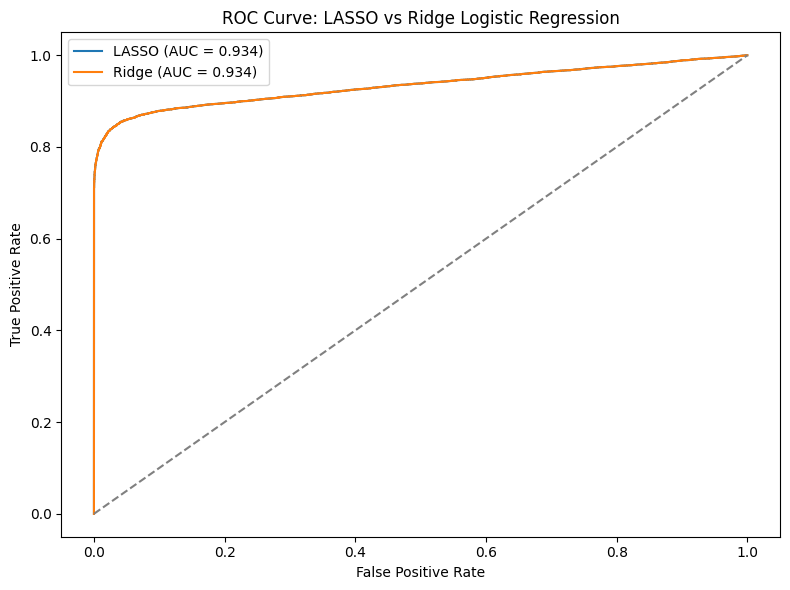

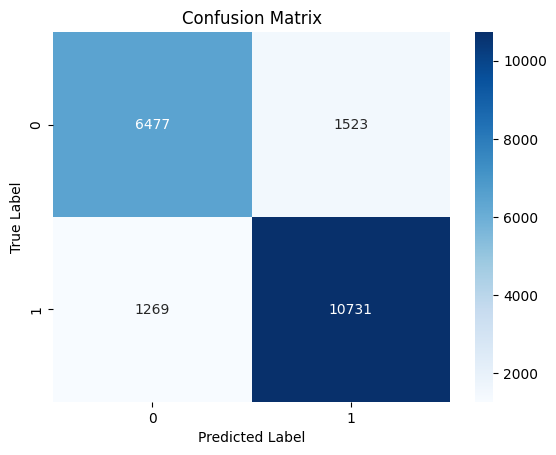

In [78]:
features_to_scale = [
    'age',
    'physical_activity_minutes_per_week',
    'glucose_fasting',
    'glucose_postprandial',
    'hba1c',
]

DS3_splits = LogisticRegressionInitialization(selected_features_high, features_to_scale)

# XGBoost Inialization

In [85]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score

def XGBoostInitialization(X_train, X_test, y_train, y_test):

    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 4, 5, 6],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0],
        'gamma': [0, 0.5, 1],
        'reg_lambda': [1, 5, 10]
    }

    xgb = XGBClassifier(
        random_state=42,
        tree_method="hist",
        n_jobs=-1
    )
    
    search = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_dist,
        n_iter=25,          
        cv=3,
        scoring='roc_auc',
        n_jobs=-1,
        random_state=42
    )
    
    search.fit(X_train, y_train)
    print(search.best_score_)
    print(search.best_params_)

    model = search.best_estimator_
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
    print(f"AUC: {roc_auc_score(y_test, y_prob):.2f}")
    return [accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_prob)]


# XGBoost DS1

In [86]:
DS1_XG = XGBoostInitialization(DS1_splits[0], DS1_splits[1], DS1_splits[2], DS1_splits[3])

0.9474510661642203
{'subsample': 0.8, 'reg_lambda': 10, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}
Accuracy: 91.99%
AUC: 0.94


# XGBoost DS2

In [87]:
DS2_XG = XGBoostInitialization(DS2_splits[0], DS2_splits[1], DS2_splits[2], DS2_splits[3])

0.9474256453980292
{'subsample': 0.8, 'reg_lambda': 10, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}
Accuracy: 91.99%
AUC: 0.94


# XGBoost DS3

In [88]:
DS3_XG = XGBoostInitialization(DS3_splits[0], DS3_splits[1], DS3_splits[2], DS3_splits[3])

0.9468251658372601
{'subsample': 0.8, 'reg_lambda': 10, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}
Accuracy: 91.99%
AUC: 0.94


# Compare models

In [89]:
metrics = pd.DataFrame({
    'Model': [
        "logistic regression DS1 Lasso", 
        "logistic regression DS1 Ridge", 
        "logistic regression DS2 Lasso", 
        "logistic regression DS2 Ridge",
        "logistic regression DS3 Lasso", 
        "logistic regression DS3 Ridge",
        "XGBoost DS1",
        "XGBoost DS2",
        "XGBoost DS3"
    ],
    'Accuracy': [
        DS1_splits[4][1], DS1_splits[5][1],
        DS2_splits[4][1], DS2_splits[5][1],
        DS3_splits[4][1], DS3_splits[5][1],
        DS1_XG[0], DS2_XG[0], DS3_XG[0]
        
    ],
    'AUC': [
        DS1_splits[4][0], DS1_splits[5][0],
        DS2_splits[4][0], DS2_splits[5][0],
        DS3_splits[4][0], DS3_splits[5][0],
        DS1_XG[1], DS2_XG[1], DS3_XG[1]
    ]
})

display(metrics)


,Model,Accuracy,AUC
0,logistic regression DS1 Lasso,0.86075,0.933736
1,logistic regression DS1 Ridge,0.86085,0.933735
2,logistic regression DS2 Lasso,0.86045,0.933749
3,logistic regression DS2 Ridge,0.86045,0.933744
4,logistic regression DS3 Lasso,0.86040,0.933799
5,logistic regression DS3 Ridge,0.86040,0.933794
6,XGBoost DS1,0.91990,0.944481
7,XGBoost DS2,0.91990,0.944421
8,XGBoost DS3,0.91990,0.943805
